In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import json

from modules.interfaces import User, DataBase
from modules.managers import PretradeDataManager, OrderManager, PortfolioManager
from modules.portfolio import *
from modules.tools import *

In [3]:
ac_info = read_json("config/mt5_account.json")["ftmo-demo"]
pre_db_info = read_json("config/postgres_info.json")["pre-trade"]
post_db_info = read_json("config/postgres_info.json")["post-trade"]
params = read_json("config/parameters.json")
asset_allocation = read_json("config/asset_allocation.json")

In [4]:
user = User().login_by_dict(ac_info)
pre_db = DataBase().connect_by_dict(pre_db_info)
post_db = DataBase().connect_by_dict(post_db_info)

Logged in as 1520230798 (FTMO-Demo2)
Connected to pre-trade (localhost:5432)
Connected to post-trade (localhost:5432)


In [5]:
pdm = PretradeDataManager(user, pre_db)
om = OrderManager(user, post_db)
pm = PortfolioManager(om, pdm, asset_allocation, params)

In [6]:
universe = pdm.get_universe()

In [7]:
forex = universe.loc[universe.asset_class == "forex"]
commodity = universe.loc[universe.asset_class == "commodity"]
metal = universe.loc[universe.asset_class == "metal"]
crypto = universe.loc[universe.asset_class == "crypto"]
equity = universe.loc[universe.asset_class == "equity"]

# Get predictors

In [8]:
import math

def sigmoid(x):
  return 1 / (1 + (-x).map(math.exp))

def clip(s):
  return s.clip(upper=s.quantile(0.99),lower=s.quantile(0.01))

def sharpe_ratio(close,lookback):
  ret = np.log(close).diff()
  mu = ret.rolling(lookback).mean()
  vol = ret.rolling(lookback).std()
  return mu/vol
def cs_rel_sharpe(sharpe,all_sharpes,smooth=False):
  med_sharpe = pd.concat(all_sharpes,axis=1).median(axis=1)
  rel_ret = sharpe - med_sharpe
  smooth_rel_ret = rel_ret.ewm(120).mean()
  if smooth:
    return smooth_rel_ret
  else:
    return rel_ret
def ts_rel_mean(close,lookback):
  ret = np.log(close).diff()
  mu = ret.rolling(lookback).mean()
  rel_mu = (mu - mu.rolling(6000).mean())/mu.rolling(6000).std()
  return rel_mu
def ts_rel_vol(close,lookback):
  ret = np.log(close).diff()
  vol = ret.rolling(lookback).std()
  rel_vol = (vol-vol.rolling(6000).min()) / (vol.rolling(6000).max()-vol.rolling(6000).min())
  return rel_vol
def ts_rel_skew(close,lookback):
  ret = np.log(close).diff()
  skew = ret.rolling(lookback).skew()
  rel_skew = (skew-skew.rolling(6000).mean()) / skew.rolling(6000).std()
  return rel_skew
def ts_rel_kurt(close,lookback):
  ret = np.log(close).diff()
  kurt = ret.rolling(lookback).kurt()
  rel_kurt = (kurt-kurt.rolling(6000).min()) / (kurt.rolling(6000).max()-kurt.rolling(6000).min())
  return rel_kurt
def ts_rel_eff(close,lookback):
  ret = np.log(close).diff(lookback)
  eff = ret/lookback
  rel_eff = (eff-eff.rolling(6000).mean()) / eff.rolling(6000).std()
  return rel_eff
def ts_rel_volume(tick_volume,lookback):
  volume_cross = tick_volume.ewm(lookback).mean()-tick_volume.ewm(lookback*4).mean()
  rel_volume = (volume_cross) / volume_cross.rolling(6000).std()
  return rel_volume
''''''
def ts_rel_vix(vix):
  rel_vix = (vix-vix.rolling(6000).mean()) / vix.rolling(6000).std()
  return rel_vix.ffill()
def uptrend_overlay(close):
  trend = np.sign(close.ewm(120).mean()-close.ewm(6000).mean()).clip(lower=0)
  return trend
def sharpe_spread(a,b):
  trend_a = np.log(a).diff().ewm(480).mean()/np.log(a).diff().ewm(480).std()
  trend_b = np.log(b).diff().ewm(480).mean()/np.log(a).diff().ewm(480).std()
  return trend_a - trend_b

# Get label

In [9]:
def momentum_ret(close,lookback):
  fast = np.log(close).ewm(lookback).mean()
  slow = np.log(close).ewm(lookback*4).mean()
  emac = (fast-slow)/(np.log(close).ewm(lookback).std().shift(-1))
  emac = emac/emac.abs().expanding().mean()
  emac = emac.clip(upper=2,lower=-2)
  signal = -emac
  
  ret = np.log(close).diff()
  pnl = np.around(signal*5)/5 * ret.shift(-1)
  return pnl

def momentum_ret_net(close,spread,lookback):
  fast = np.log(close).ewm(lookback).mean()
  slow = np.log(close).ewm(lookback*4).mean()
  emac = (fast-slow)/(np.log(close).ewm(lookback).std().shift(-1))
  emac = emac/emac.abs().expanding().mean()
  emac = emac.clip(upper=2,lower=-2)
  signal = -emac
  
  ret = np.log(close).diff()
  cost = spread/close/2 + 0.00003
  pnl = np.around(signal*5)/5 * ret.shift(-1) - signal.diff().abs() * cost
  return pnl

def meta_momentum_ret_net(close,spread,meta_scale,lookback):
  fast = np.log(close).ewm(lookback).mean()
  slow = np.log(close).ewm(lookback*4).mean()
  emac = (fast-slow)/(np.log(close).ewm(lookback).std().shift(-1))
  emac = emac/emac.abs().expanding().mean()
  emac = emac.clip(upper=2,lower=-2)
  signal = -emac*meta_scale.rolling(lookback).mean()
  
  ret = np.log(close).diff()
  cost = spread/close/2 + 0.00003
  pnl = np.around(signal*5)/5 * ret.shift(-1) - signal.diff().abs() * cost
  return pnl

def pnl_label(pnl,lookforward):
  pnl_sum = pnl.rolling(lookforward).sum().shift(lookforward-1)
  label = np.sign(pnl_sum).clip(lower=0)
  return label

from modules.trading_models.indicators import TechnicalIndicator

def bb_ret(close,lookback):
  ti = TechnicalIndicator(close=close)
  ema, upper, lower = ti.get_bb(lookback,48,6000,1)
  long_pos = np.where(close<=lower,1,0)
  short_pos = np.where(close>=upper,-1,0)
  signal = pd.Series(long_pos + short_pos,index=close.index)
  ret = np.log(close).diff()
  pnl = signal * ret.shift(-1)
  return pnl

# Get bars

In [10]:
import yfinance as yf

vix = yf.download("VIXY").Close
vixm = yf.download('VIXM').Close
equity_close = yf.download("SPY").Close
qqq = yf.download('QQQ').Close
bond_close = yf.download("BND").Close
rf = yf.download("IEI").Close

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [11]:
dfs = dict()

sharpes = dict()

strat_span = 120

spans = [120,480]
for span in spans:
  sharpes[span] = list()
  
symbols = ["EURUSD","AUDNZD","AUDUSD","EURGBP","NZDUSD","GBPUSD","USDCAD","USDCHF","EURCHF","AUDCAD","AUDCHF","EURAUD","NZDCAD","NZDCHF","EURNZD","GBPNZD","CADCHF"]
symbols = ['EURUSD', 'GBPUSD', 'EURCHF', 'GBPCHF', 'EURJPY', 'GBPJPY']
symbols = ['NZDUSD', 'AUDCAD', 'NZDCHF', 'NZDJPY']
#symbols = ["EURUSD","AUDNZD","AUDUSD","GBPUSD","USDCAD","EURGBP","EURAUD","GBPNZD","USDJPY","EURNZD","USDCHF","EURCHF","NZDUSD","USDHKD","GBPAUD","EURJPY","AUDCAD","AUDJPY","EURCAD","GBPCAD","GBPJPY","NZDJPY","GBPCHF","NZDCAD","AUDCHF","CHFJPY","USDSEK","CADJPY","EURNOK","USDMXN"]
#symbols = ["AUDNZD","US30.cash","AUDUSD","GBPUSD","USDCAD","GER40.cash","EURGBP","EURAUD","GBPNZD","USDJPY","EURNZD","XAUUSD","SOYBEAN.c","USDCHF","EURCHF","NZDUSD","USDHKD","XAUAUD","GBPAUD","EURJPY","US2000.cash","AUDCAD","FRA40.cash","COCOA.c","AUDJPY","EURCAD","GBPCAD","US100.cash","GBPJPY","US500.cash","NZDJPY","GBPCHF","NZDCAD","AUDCHF","CHFJPY","JP225.cash","AUS200.cash","WHEAT.c","XAUEUR","USDSEK","CADJPY","EURNOK","COFFEE.c","USDMXN","USDNOK","CORN.c","NZDCHF","CADCHF","UKOIL.cash","HK50.cash","XAGAUD"]
# symbols = forex.symbol.to_list()


for symbol in symbols:
  bars = pdm.get_bars(symbol)
  
  df = pd.DataFrame()
  pnl = momentum_ret(bars.close,strat_span)
  df['label'] = pnl_label(pnl,strat_span)
  
  for span in spans:
    df[f'sharpe_ratio{span}'] = sharpe_ratio(bars.close,span)
    sharpes[span].append(df[f'sharpe_ratio{span}'])
    df[f'ts_rel_mean{span}'] = clip(ts_rel_mean(bars.close,span))
    df[f'ts_rel_vol{span}'] = np.sqrt(clip(ts_rel_vol(bars.close,span)))
    df[f'ts_rel_skew{span}'] = clip(ts_rel_skew(bars.close,span))
    df[f'ts_rel_kurt{span}'] = np.sqrt(clip(ts_rel_kurt(bars.close,span)))
    #df[f'ts_rel_eff{span}'] = clip(ts_rel_eff(bars.close,span))
    df[f'ts_rel_volume{span}'] = clip(ts_rel_volume(bars.tick_volume,span))
    #df[f'ts_rel_vix{span}'] = clip(ts_rel_vix(vix.reindex(bars.index).interpolate()))
    #df[f'equity_sharpe{span}'] = sharpe_ratio(equity_close.reindex(bars.index).interpolate(),span)
    #df[f'bond_sharpe{span}'] = sharpe_ratio(bond_close.reindex(bars.index).interpolate(),span)
  
  #df['trend_underlying'] = trend_overlay(bars.close)
  df['trend_vix'] = uptrend_overlay(vix.reindex(bars.index).ffill())
  df['trend_equity'] = uptrend_overlay(equity_close.reindex(bars.index).ffill())
  df['trend_bond'] = uptrend_overlay(bond_close.reindex(bars.index).ffill())
  
  df['equity_spread'] = sharpe_spread(equity_close.reindex(bars.index).ffill(),qqq.reindex(bars.index).ffill())
  df['bond_spread'] = sharpe_spread(bond_close.reindex(bars.index).ffill(),rf.reindex(bars.index).ffill())
  df['vix_spread'] = sharpe_spread(vix.reindex(bars.index).ffill(),vixm.reindex(bars.index).ffill())
  
  dfs[symbol] = df
  
for symbol in symbols:
  for span in spans:
    dfs[symbol][f'cs_rel_sharpe{span}'] = cs_rel_sharpe(dfs[symbol][f'sharpe_ratio{span}'],sharpes[span],smooth=True)
  print(symbol,end=' ')
  print(len(dfs[symbol].dropna()))


NZDUSD 61904
AUDCAD 61988
NZDCHF 61738
NZDJPY 61904


In [12]:
concat_df = pd.concat([df.dropna()[::] for df in dfs.values()],axis=0)

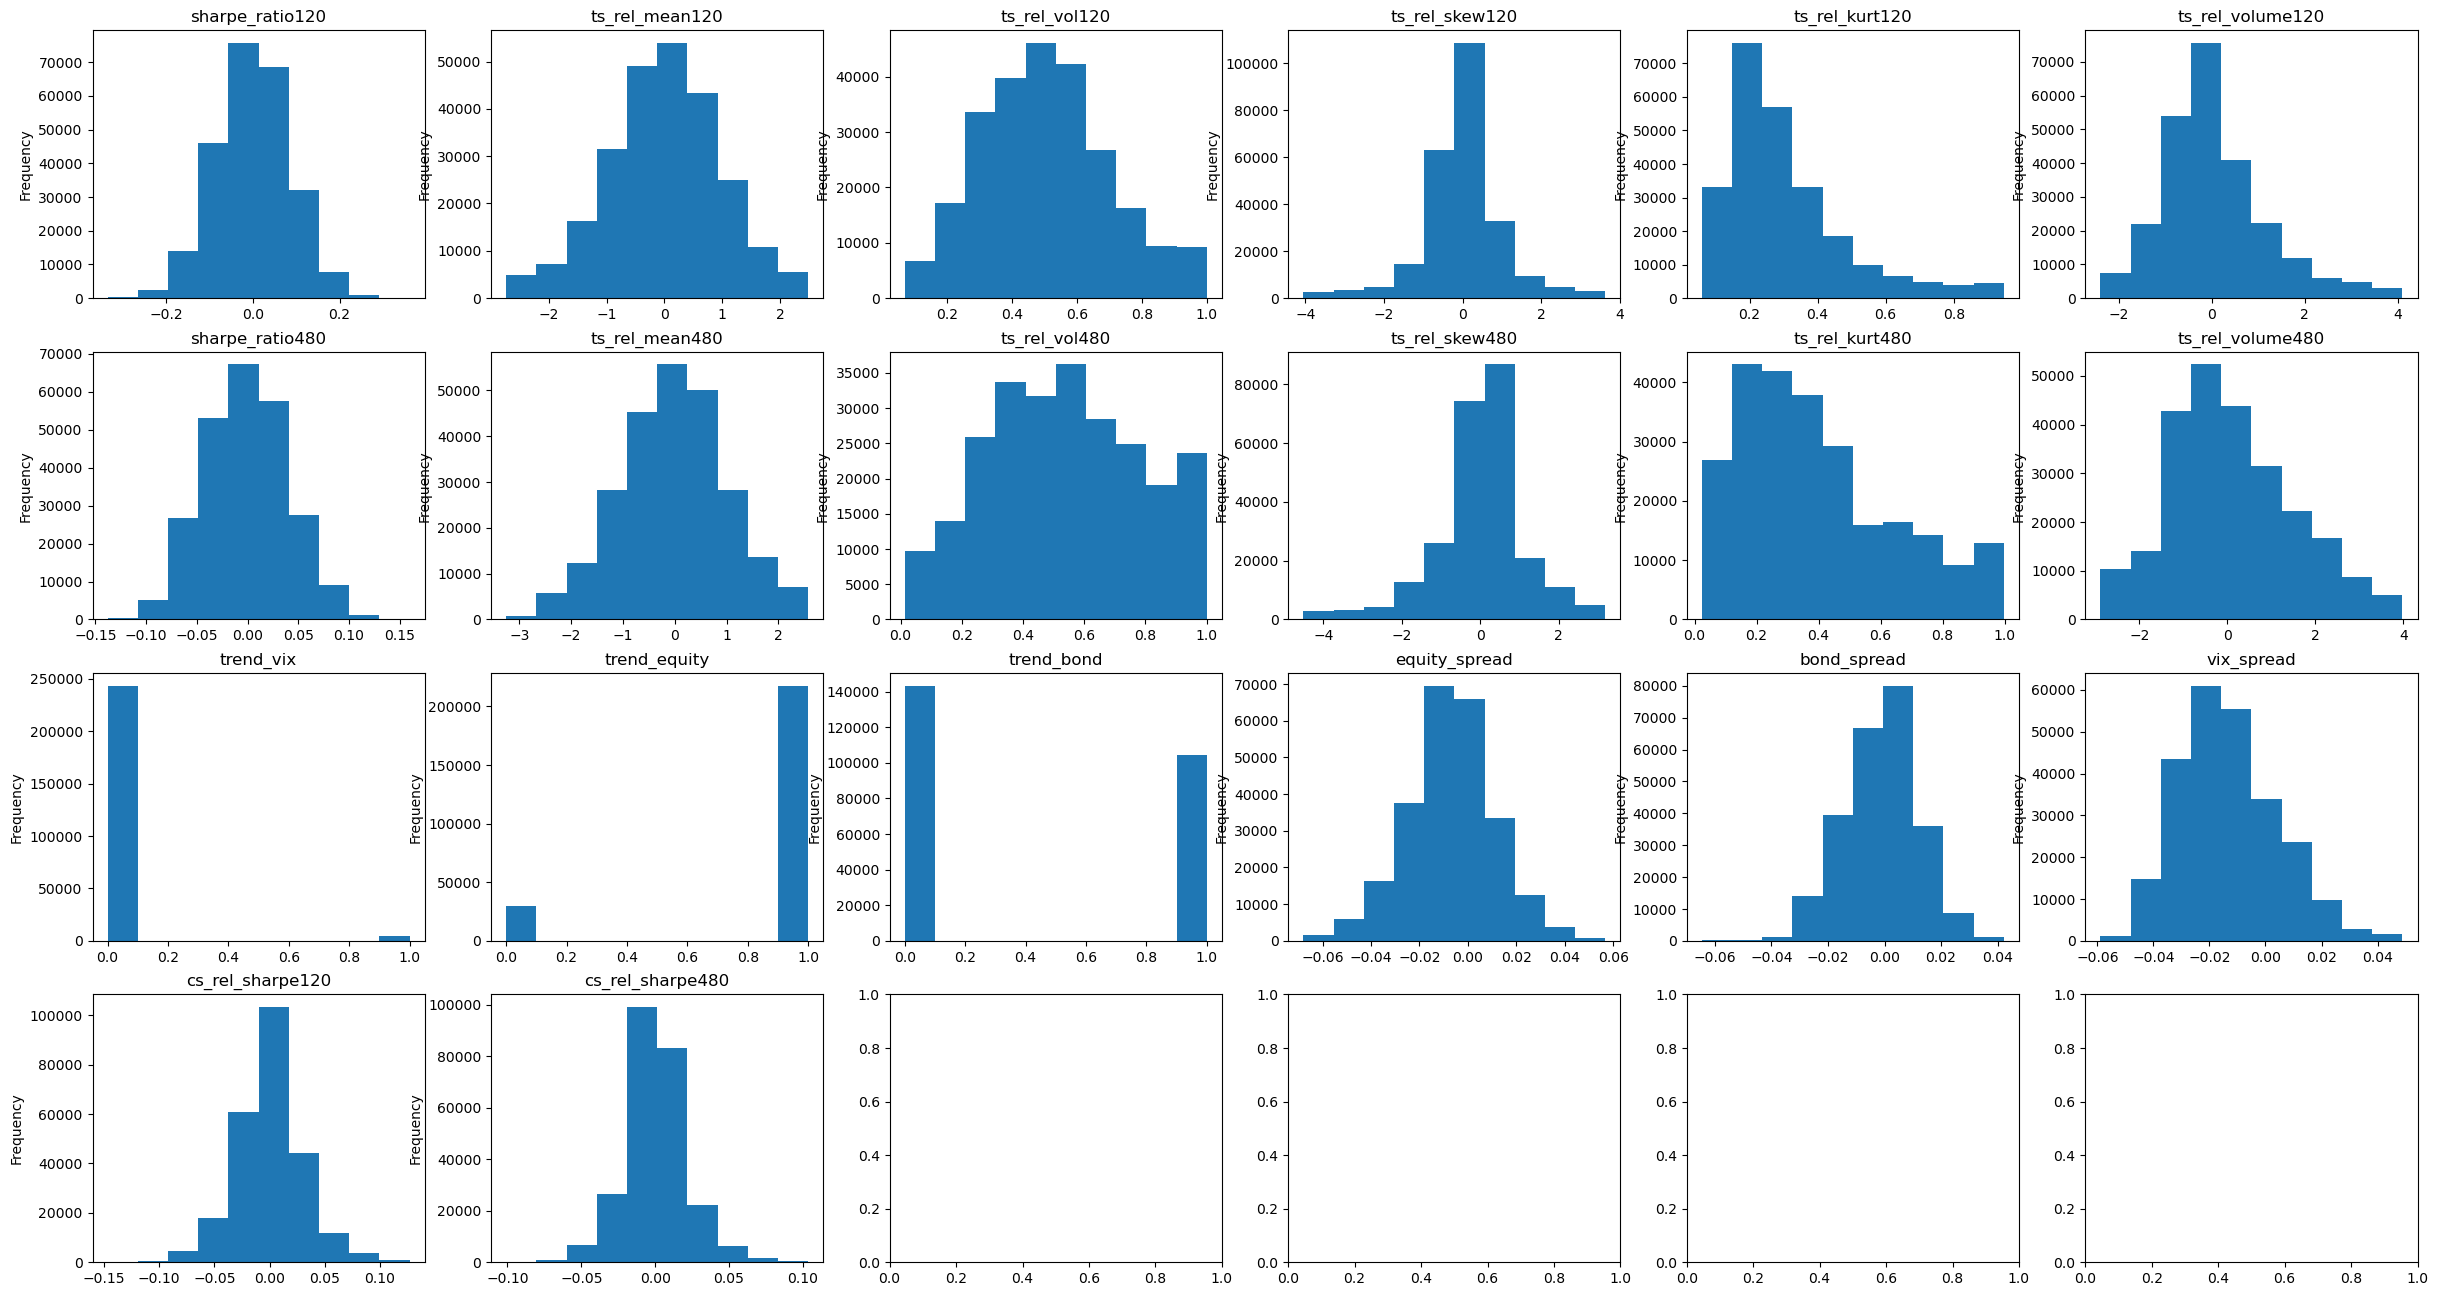

In [13]:
nc = 6
nr = len(concat_df.columns)//nc+1
fig,axes = plt.subplots(nr,nc,figsize=(nc*5,nr*4))
for i,col in enumerate(concat_df.columns[1:]):
  r,c = i//nc,i%nc
  concat_df[col].plot(kind='hist',ax=axes[r,c],title=col)

In [14]:
# compare with statsmodels
import statsmodels.api as sm

x = concat_df.drop(columns='label').sort_index().reset_index(drop=True).dropna()
y = concat_df.label.sort_index().reset_index(drop=True).dropna()

train_x = x.iloc[:len(x)//2]
test_x = x.iloc[len(x)//2:]
train_y = y.iloc[:len(y)//2]
test_y = y.iloc[len(y)//2:]

sm_model = sm.Logit(train_y, (train_x)).fit(disp=0)
#print(sm_model.pvalues)
sm_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  label   No. Observations:               123767
Model:                          Logit   Df Residuals:                   123747
Method:                           MLE   Df Model:                           19
Date:                Sun, 02 Jun 2024   Pseudo R-squ.:                 0.01672
Time:                        22:23:08   Log-Likelihood:                -83572.
converged:                       True   LL-Null:                       -84993.
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sharpe_ratio120     -0.6240      0.280     -2.228      0.026      -1.173      -0.075
ts_rel_mean120      -0.0608      0.024     -2.520      0.012      -0.108      -0.014
ts_rel_vol120       -0.7884      0.052    -15.215      0.000      -0.890      -0.687
ts_rel_skew120       0.0696      0.007      9.959      0.000       0.056       0.083
ts_rel_kurt120       0.4686      0.043     10.813      0.000       0.384       0.554
ts_rel_volume120    -0.0256      0.006     -3.990      0.000      -0.038      -0.013
sharpe_ratio480     -1.5858      0.506     -3.135      0.002      -2.577      -0.594
ts_rel_mean480       0.2116      0.020     10.672      0.000       0.173       0.250
ts_rel_vol480        1.4461      0.041     35.046      0.000       1.365       1.527
ts_rel_skew480      -0.0253      0.006     -4.030      0.000      -0.038      -0.013
ts_rel_kurt480      -0.3732      0.030    -12.349      0.000      -0.432      -0.314
ts_rel_volume480    -0.0546      0.006     -9.914      0.000      -0.065      -0.044
trend_vix            0.3379      0.102      3.314      0.001       0.138       0.538
trend_equity        -0.3192      0.017    -18.930      0.000      -0.352      -0.286
trend_bond           0.2449      0.013     19.301      0.000       0.220       0.270
equity_spread       -3.2239      0.335     -9.629      0.000      -3.880      -2.568
bond_spread          0.5408      0.571      0.947      0.344      -0.579       1.660
vix_spread          -1.5645      0.377     -4.145      0.000      -2.304      -0.825
cs_rel_sharpe120    -0.1931      0.247     -0.781      0.435      -0.678       0.292
cs_rel_sharpe480     1.5292      0.356      4.292      0.000       0.831       2.228
====================================================================================
"""

In [15]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

#model = LogisticRegressionCV(fit_intercept=False,penalty='l2',max_iter=500,cv=5,n_jobs=-1)
#model = RandomForestClassifier(n_estimators=100,max_depth=5,random_state=300300,n_jobs=-1)
model = HistGradientBoostingClassifier(random_state=300300)

x = concat_df.drop(columns='label').sort_index()
y = concat_df.label.sort_index()

train_x = x.iloc[:len(x)//2]
test_x = x.iloc[len(x)//2:]
train_y = y.iloc[:len(y)//2]
test_y = y.iloc[len(y)//2:]

model.fit(train_x,train_y)

HistGradientBoostingClassifier(random_state=300300)

In [16]:
model.score(train_x,train_y)

0.8735123255795163

In [17]:
model.score(test_x,test_y)

0.5933003143002578

In [18]:
pnls = dict()
meta_pnls = dict()

for symbol in symbols:
    print(symbol,end=' ')
    bars = pdm.get_bars(symbol)
    spread = bars.spread * universe.loc[universe.symbol == symbol].point.values[0]
    # print(spread)

    df = dfs[symbol].dropna()
    
    start_year = 2016
    pred_l = list()
    for i in range(8):
        year = start_year + i
        print(year,end=' ')
        
        model = HistGradientBoostingClassifier(random_state=300300)

        x = concat_df.drop(columns='label').sort_index().loc[:str(year)]
        y = concat_df.label.sort_index().loc[:str(year)]
        
        model.fit(x,y)
        x = df.drop(columns="label").loc[str(year):str(year+1)]
        try:
            pred_l.append(pd.Series(np.sign(model.predict_proba(x)[:, 1] - 0.5), x.index))
        except:
            print('n',end=' ')
    
    pred = pd.concat(pred_l)
    pred = pred[~pred.index.duplicated(keep='first')]
    
    meta_scale = 0.75 + 0.25 * pred
    meta_pnls[symbol] = meta_momentum_ret_net(
        bars.close, spread, meta_scale, strat_span
    ).dropna()
    
    pnls[symbol] = (
        momentum_ret_net(bars.close, spread, strat_span).dropna()
    ).loc[meta_pnls[symbol].index].dropna()
    
    print()

NZDUSD 2016 2017 2018 2019 2020 2021 2022 2023 
AUDCAD 2016 2017 2018 2019 2020 2021 2022 2023 
NZDCHF 2016 2017 2018 2019 2020 2021 2022 2023 
NZDJPY 2016 2017 2018 2019 2020 2021 2022 2023 


In [19]:
from scipy.stats import ttest_ind

for symbol in symbols:
  pnl = pnls[symbol].resample('d').sum()
  meta_pnl = meta_pnls[symbol].resample('d').sum()
  
  info_ratio = (meta_pnl-pnl).mean()/(meta_pnl-pnl).std()*np.sqrt(250)
  
  #result = ttest中中ind(meta_pnl,pnl)
  
  print(symbol,f'meta:{meta_pnl.mean()/meta_pnl.std()*np.sqrt(250):.2f} pnl:{pnl.mean()/pnl.std()*np.sqrt(250):.2f} ir:{info_ratio:.2f}')

NZDUSD meta:0.21 pnl:0.22 ir:-0.17
AUDCAD meta:0.07 pnl:0.13 ir:-0.30
NZDCHF meta:0.19 pnl:0.25 ir:-0.32
NZDJPY meta:0.55 pnl:0.42 ir:0.09


In [20]:
sr = [pnls[symbol].resample('d').sum().mean()/pnls[symbol].resample('d').sum().std() for symbol in symbols]
meta_sr = [meta_pnls[symbol].resample('d').sum().mean()/meta_pnls[symbol].resample('d').sum().std() for symbol in symbols]

result = ttest_ind(sr,meta_sr)
result.statistic , result.pvalue

(0.006841734691224248, 0.9947629354951616)

In [21]:
scaler_pnl = .2/16/pd.concat(pnls,axis=1).mean(axis=1).resample('d').sum().std()
scaler_meta = .2/16/pd.concat(meta_pnls,axis=1).mean(axis=1).resample('d').sum().std()
scaler_pnl,scaler_meta

(3.2030019269239713, 3.931708263082469)

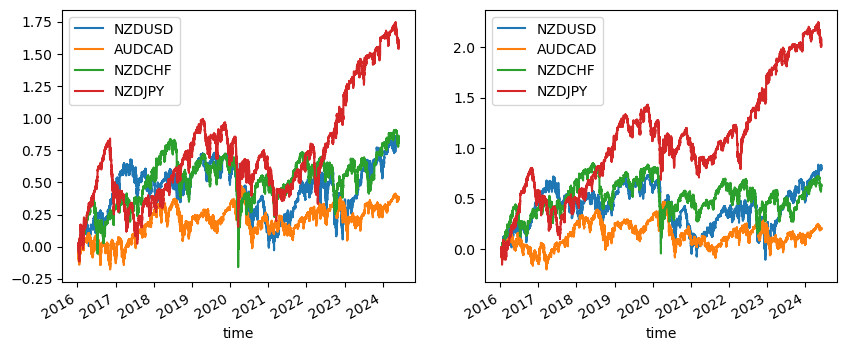

In [22]:
fig,axes = plt.subplots(1,2,figsize=(2*5,4))
for symbol in symbols:
  pnl = scaler_pnl*pnls[symbol]
  meta_pnl = scaler_meta*meta_pnls[symbol]
  
  pnl.cumsum().plot(ax=axes[0])
  meta_pnl.cumsum().plot(ax=axes[1])
  
axes[0].legend(symbols)
axes[1].legend(symbols)

In [23]:
weight = pd.DataFrame({'EURUSD':.2/np.sqrt(6000)/TechnicalIndicator(close=pdm.get_bars('EURUSD').close).get_combvol(48,6000),
          'EURCHF':.2/np.sqrt(6000)/TechnicalIndicator(close=pdm.get_bars('EURUSD').close).get_combvol(48,6000),
          'EURJPY':.2/np.sqrt(6000)/TechnicalIndicator(close=pdm.get_bars('EURUSD').close).get_combvol(48,6000),
          'GBPUSD':.2/np.sqrt(6000)/TechnicalIndicator(close=pdm.get_bars('EURUSD').close).get_combvol(48,6000),
          'GBPCHF':.2/np.sqrt(6000)/TechnicalIndicator(close=pdm.get_bars('EURUSD').close).get_combvol(48,6000),
          'GBPJPY':.2/np.sqrt(6000)/TechnicalIndicator(close=pdm.get_bars('EURUSD').close).get_combvol(48,6000)})

In [24]:
result = ttest_ind(scaler_pnl*pd.concat(pnls,axis=1).mean(axis=1),(scaler_meta*pd.concat(meta_pnls,axis=1).mean(axis=1)))
result.statistic,result.pvalue

(-0.01833926747623778, 0.9853682368481453)

<Axes: xlabel='time'>

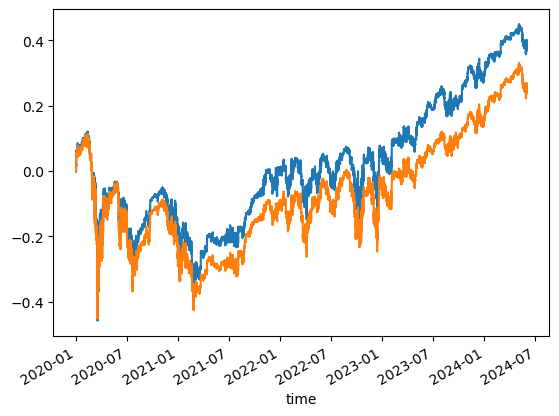

In [25]:
(scaler_pnl*pd.concat(pnls.values(),axis=1).mean(axis=1)).loc['2020':].cumsum().plot()
(scaler_meta*pd.concat(meta_pnls.values(),axis=1).mean(axis=1)).loc['2020':].cumsum().plot()

In [26]:
(scaler_meta*pd.concat(pnls,axis=1).mean(axis=1)).resample('d').sum().mean()/(scaler_meta*pd.concat(pnls,axis=1).mean(axis=1)).resample('d').sum().std()*16

0.36618687722874455

In [ ]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    model, test_x, test_y, n_repeats=20, random_state=300300, n_jobs=-1
)

forest_importances = pd.Series(result.importances_mean, index=x.columns)

NameError: name 'forest_importances' is not defined

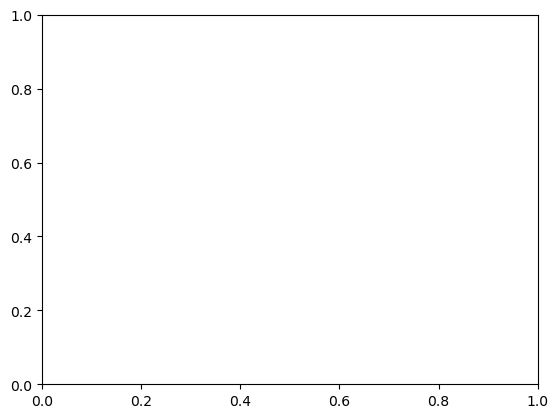

In [27]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()